In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from scipy.integrate import trapz
import scipy.stats as st

Define (log) likelihood. Just a normal distribution centered at $a$: $\log L(d)\sim -\frac{1}{2\sigma^2}\Sigma_{i=1}^N(d_i-a)^2$

In [8]:
def logL(data,sigma,a):
    retval = 0.0
    for d in data:
        retval -= (d-a)*(d-a)
    retval *= 1./(2.*sigma*sigma)
    return retval

Define simple function to create credible intervals:

In [9]:
def CI(hist,interval):
    binwidth = hist[1][1]-hist[1][0]
    i = 0
    while np.sum(binwidth*hist[0][0:i]) < (1-interval)/2.:
        i += 1
    lower = hist[1][i]
    while np.sum(binwidth*hist[0][0:i]) < 1-(1-interval)/2.:
        i += 1
        if i == len(hist[0]):
            break
    upper = hist[1][i+1]
    return [lower,upper]

Make our data sample:

In [10]:
a = 0.3
sigma = 1.0
N_data = 1000
data = np.random.normal(a,sigma,N_data)
print(np.mean(data))

0.362413976072


Plot our data because why not

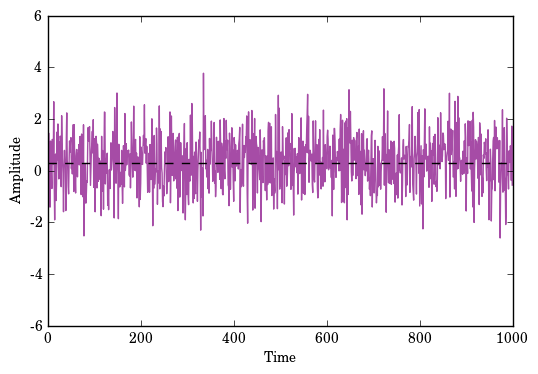

In [11]:
plt.plot(data,color='purple',alpha=0.7)
plt.plot([0,len(data)],[a,a],'k--')
plt.ylim(-6,6)
plt.rc('text',usetex=True)
plt.rc('font', family='serif')
plt.ylabel('Amplitude')
plt.xlabel('Time')

Define paramters of our MCMC:

In [12]:
Niter = 50000 # number of MCMC iterations
thin = 10 # how many points in the chain you want to keep (ie thin=10 keeps every 10th point)
burnin = int(Niter/5/10) # how many burnin samples to discard
amax = 3.0 # defines volume of prior
sigma_proposal = 0.1 # width of proposal density: try changing this and see how it affects the chains

In [13]:
# initialize some stuff
a_chain = []
logL_chain = []

ax = np.random.uniform(0,amax) # initial a value a draw from the prior
logLx = logL(data,sigma,ax)

acc = 0

# This is the actual MCMC
for i in range(0,Niter):
    test = 0
    ay = ax+np.random.normal(0,sigma_proposal) # x is current, y is propose
    if (ay < 0 or ay > amax): # check that we haven't mapped outside prior range
        test = 1
    logLy = logL(data,sigma,ay)
    #logLy = logLx = 1 # uncomment this for constant likelihood check (should return your prior)
    u = np.log(np.random.random())
    if (logLy-logLx) < u: # check metropolis hastings ratio 
        test = 2
    if test == 0: # if inside prior range && accepted by MH ratio, update parameters 
        ax = ay
        logLx = logLy
        acc += 1
    if i%thin==0:
        a_chain.append(ax)
        logL_chain.append(logLx)
        
print('Acceptance ratio = {0}'.format(acc/Niter))

Acceptance ratio = 0.35786


Plot chain and histogram

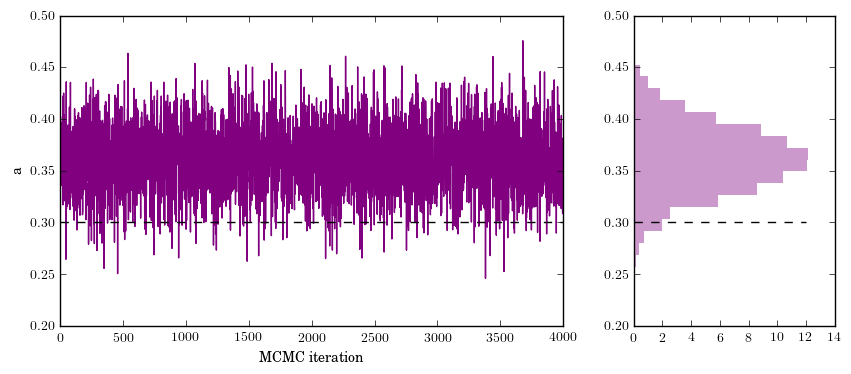

In [27]:
f, (a0, a1) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[5, 2]},figsize=(10, 4))
a0.plot(a_chain[burnin::],color='purple')
a0.plot([0,len(a_chain[burnin::])],[a,a],'k--')
a0.set_xlabel('MCMC iteration')
a0.set_ylabel('a')
hist = a1.hist(a_chain[burnin::],bins=20,alpha=0.4,edgecolor='none',normed=True,color='purple',orientation=u'horizontal');
a1.plot([0,12],[a,a],'k--')

Check against predicted posterior distribution: A truncated Gaussian ($a,a_\mathrm{max}$), with mean $\bar{d}$ and variance $1/N_\mathrm{data}$ (details in Romano+Cornish LRR)

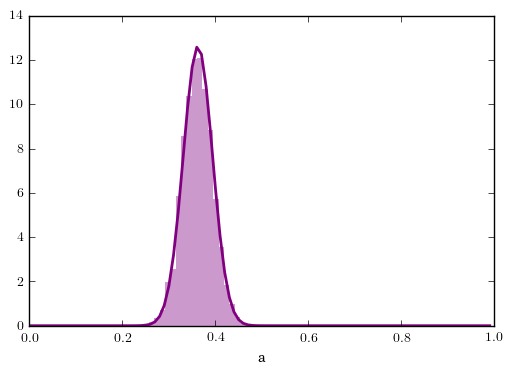

In [28]:
hist = plt.hist(a_chain[burnin::],bins=20,alpha=0.4,edgecolor='none',normed=True,color='purple')
xvals = np.arange(0,1,.01)
plt.plot(xvals,st.norm.pdf(xvals,np.mean(data),math.sqrt(1./len(data))),color='purple',lw=2)
plt.xlabel('a')
plt.show()

And also check 90% credible intervals, because why not

In [9]:
CI90 = CI(hist,.9)
print(CI90)

[0.22312507572053991, 0.33109672137838253]


----------------------------------------------------------------------------------------------------------------------